In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
dataset = pd.read_csv("C:/Users/aruni/PycharmProjects/pythonProject6/Bitcoin123.csv")
dataset.head()

,Date,Open,High,Low,Close,Volume,Currency
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,21056800.0,USD
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,34483200.0,USD
2,19-09-2014,424.102997,427.834992,384.532013,394.795990,37919700.0,USD
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,36863600.0,USD
4,21-09-2014,408.084992,412.425995,393.181000,398.821014,26580100.0,USD


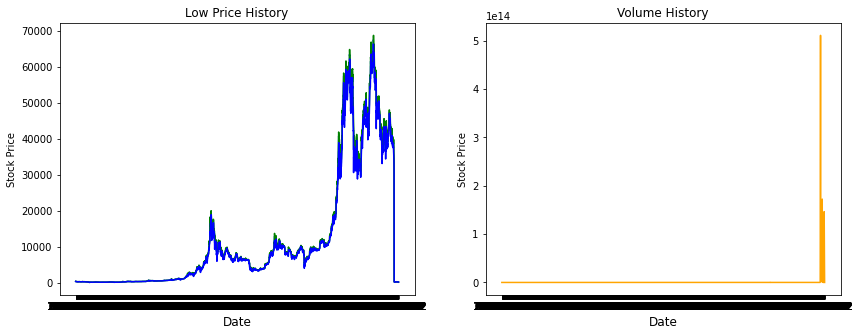

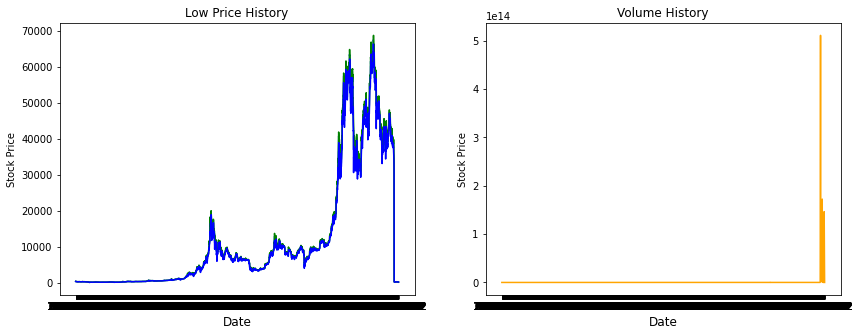

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(dataset["Date"], dataset["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Price History")

# Second Subplot
ax1.plot(dataset["Date"], dataset["High"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("High Price History")

# Third Subplot
ax1.plot(dataset["Date"], dataset["Low"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Low Price History")

# Fourth Subplot
ax2.plot(dataset["Date"], dataset["Volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Volume History")
plt.show()

In [41]:

dataset['Date'] = pd.to_datetime(dataset['Date'], format=('%d-%m-%Y'))
group = dataset.groupby('Date')

In [42]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2831 entries, 0 to 2830
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2831 non-null   datetime64[ns]
 1   Open      2831 non-null   float64       
 2   High      2831 non-null   float64       
 3   Low       2831 non-null   float64       
 4   Close     2831 non-null   float64       
 5   Volume    2831 non-null   float64       
 6   Currency  2831 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 154.9+ KB


,Date,Open,High,Low,Close,Volume,Currency
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,USD
2,2014-09-19,424.102997,427.834992,384.532013,394.795990,37919700.0,USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,USD
4,2014-09-21,408.084992,412.425995,393.181000,398.821014,26580100.0,USD


In [44]:
date1 = datetime(2014, 9, 17)
date2 = datetime(2022, 6, 17)

day_price = group['Close'].mean()

delta = date2 - date1
days_look = delta.days + 1

data = day_price[len(day_price) - days_look:len(day_price)]

scl = MinMaxScaler()

data = data.values.reshape(data.shape[0], 1)
scale_data = scl.fit_transform(data)

In [45]:
SEQ_LEN = 50
WINDOW_SIZE = SEQ_LEN - 1

BATCH_SIZE=64

DROPOUT = 0.2


def load_data(data_raw, seq_len):
    data = []

    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    train_split = 0.8

    num_data = data.shape[0]

    num_train = int(train_split * num_data)

    data = np.array(data)

    x_train = data[:num_train, :-1, :]

    y_train = data[:num_train, -1, :]

    x_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return [x_train, y_train, x_test, y_test]


x_train, y_train, x_test, y_test = load_data(scale_data, SEQ_LEN)

In [46]:
from keras.callbacks import EarlyStopping
from keras.layers import GRU, Dropout

model_name = 'GRU'

model = Sequential()
model.add(GRU(units=100,
              return_sequences=True,
              input_shape=(WINDOW_SIZE,x_train.shape[-1])))
model.add(Dropout(DROPOUT))
model.add(GRU(units=100))
model.add(Dropout(DROPOUT))
model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

print(model.summary())



# Set activation function
#model.add(Activation('relu'))
# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 49, 100)           30900     
                                                                 
 dropout_9 (Dropout)         (None, 49, 100)           0         
                                                                 
 gru_6 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
35/35 [==========================

18/18 [==============================] - 1s 21ms/step


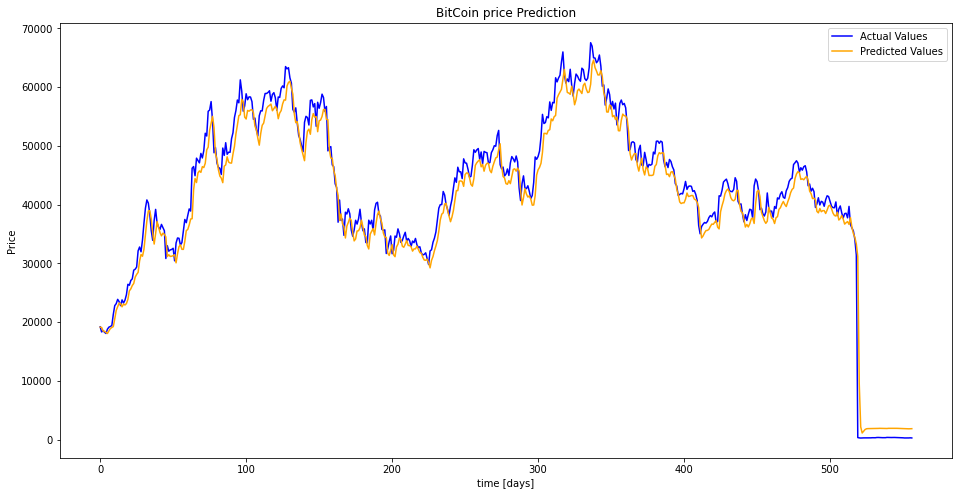

In [47]:
predict_prices = model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='blue')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='Orange')

plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

In [48]:
lookback_period = 5


testX_last_5_days = x_test[x_test.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(5, 49, 1)

In [49]:
testX_last_5_days.reshape(-1,)

array([0.58305288, 0.59772915, 0.56299266, 0.57966697, 0.58757196,
       0.57029898, 0.55701858, 0.56821064, 0.56910448, 0.55754653,
       0.58645223, 0.54010575, 0.53217833, 0.52418042, 0.50277198,
       0.46369346, 0.00237838, 0.00162177, 0.00124466, 0.00155628,
       0.00162385, 0.00172336, 0.00156473, 0.00167804, 0.00167181,
       0.00175034, 0.00205201, 0.0019664 , 0.00198705, 0.00257585,
       0.00268141, 0.00247639, 0.00249659, 0.002146  , 0.00224955,
       0.00218087, 0.00281184, 0.00269922, 0.00267149, 0.00253039,
       0.00269179, 0.00269179, 0.00257191, 0.00236786, 0.00212064,
       0.00216845, 0.00214481, 0.00180205, 0.00142761, 0.59772915,
       0.56299266, 0.57966697, 0.58757196, 0.57029898, 0.55701858,
       0.56821064, 0.56910448, 0.55754653, 0.58645223, 0.54010575,
       0.53217833, 0.52418042, 0.50277198, 0.46369346, 0.00237838,
       0.00162177, 0.00124466, 0.00155628, 0.00162385, 0.00172336,
       0.00156473, 0.00167804, 0.00167181, 0.00175034, 0.00205

In [50]:
predicted_5_days_forecast_price_test_x = []

for i in range(5):
  predicted_forecast_price_test_x = model.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scl.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))

1/1 [==============================] - 0s 38ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[1845.0618]]

 [[1837.8323]]

 [[1830.6311]]

 [[1839.1769]]

 [[1855.0066]]]


In [51]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.reshape(-1,)

array([1845.0618, 1837.8323, 1830.6311, 1839.1769, 1855.0066],
      dtype=float32)

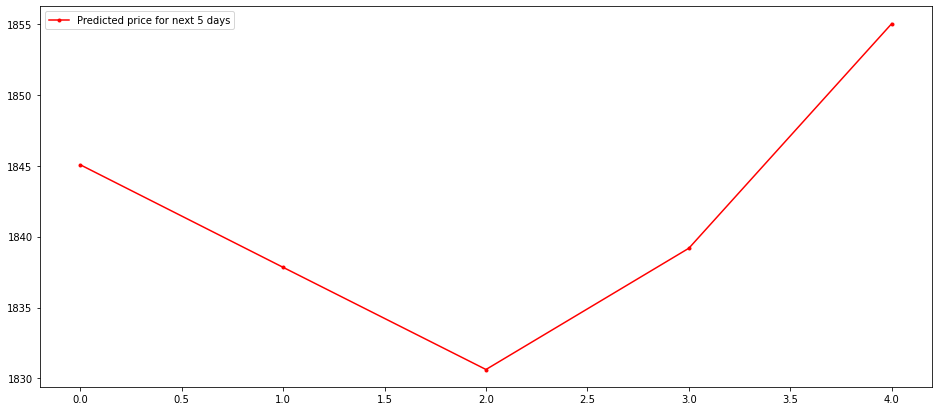

In [52]:
plt.figure(figsize=(16,7))

plt.plot(predicted_5_days_forecast_price_test_x.reshape(-1,)
, 'r', marker='.', label='Predicted price for next 5 days')



plt.legend()

plt.show()

In [53]:
from keras.layers import Bidirectional, Dropout, Activation

model = Sequential()

# First Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, x_train.shape[-1])))
model.add(Dropout(DROPOUT))

# Second Layer
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(DROPOUT))

# Third Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

# Set activation function
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 49, 98)           19992     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 49, 98)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 49, 196)          154448    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 49, 196)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 98)               96432     
 nal)                                                            
                                                      

In [54]:
from keras.callbacks import EarlyStopping

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Epoch 1/100
35/35 [==============================] - 18s 255ms/step - loss: 0.0018 - val_loss: 0.0286
Epoch 2/100
35/35 [==============================] - 6s 173ms/step - loss: 0.0018 - val_loss: 0.0085
Epoch 3/100
35/35 [==============================] - 6s 178ms/step - loss: 0.0019 - val_loss: 0.0348
Epoch 4/100
35/35 [==============================] - 6s 175ms/step - loss: 0.0021 - val_loss: 0.0389
Epoch 5/100
35/35 [==============================] - 7s 190ms/step - loss: 9.1299e-04 - val_loss: 0.0140
Epoch 6/100
35/35 [==============================] - 7s 196ms/step - loss: 0.0014 - val_loss: 0.0579
Epoch 7/100
35/35 [==============================] - 7s 196ms/step - loss: 9.3797e-04 - val_loss: 0.0105
Epoch 8/100
35/35 [==============================] - 7s 202ms/step - loss: 8.3107e-04 - val_loss: 0.0303
Epoch 9/100
35/35 [==============================] - 7s 195ms/step - loss: 6.8098e-04 - val_loss: 0.0141
Epoch 10/100
35/35 [==============================] - 7s 197ms/step - loss

18/18 [==============================] - 4s 32ms/step


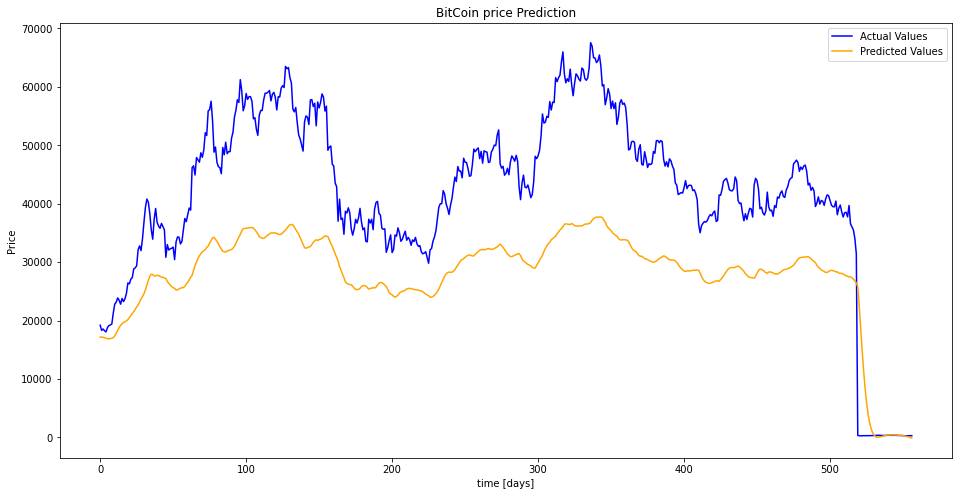

In [55]:
predict_prices = model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='blue')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='Orange')

plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

In [64]:
lookback_period = 30


testX_last_5_days = x_test[x_test.shape[0] - lookback_period :  ]

testX_last_5_days.shape
testX_last_5_days.reshape(-1,)

array([0.5991412 , 0.59722723, 0.58672797, 0.60318862, 0.61322791,
       0.61132297, 0.59875387, 0.58707473, 0.58331164, 0.58305288,
       0.59772915, 0.56299266, 0.57966697, 0.58757196, 0.57029898,
       0.55701858, 0.56821064, 0.56910448, 0.55754653, 0.58645223,
       0.54010575, 0.53217833, 0.52418042, 0.50277198, 0.46369346,
       0.00237838, 0.00162177, 0.00124466, 0.00155628, 0.00162385,
       0.00172336, 0.00156473, 0.00167804, 0.00167181, 0.00175034,
       0.00205201, 0.0019664 , 0.00198705, 0.00257585, 0.00268141,
       0.00247639, 0.00249659, 0.002146  , 0.00224955, 0.00218087,
       0.00281184, 0.00269922, 0.00267149, 0.00253039, 0.59722723,
       0.58672797, 0.60318862, 0.61322791, 0.61132297, 0.59875387,
       0.58707473, 0.58331164, 0.58305288, 0.59772915, 0.56299266,
       0.57966697, 0.58757196, 0.57029898, 0.55701858, 0.56821064,
       0.56910448, 0.55754653, 0.58645223, 0.54010575, 0.53217833,
       0.52418042, 0.50277198, 0.46369346, 0.00237838, 0.00162

In [69]:
predicted_5_days_forecast_price_test_x = []

for i in range(30):
  predicted_forecast_price_test_x = model.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scl.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))

1/1 [==============================] - 0s 35ms/step


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [72]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.reshape(-1,)

array([ 423.32477 ,  422.36514 ,  413.7043  ,  382.9787  ,  365.0377  ,
        355.6128  ,  344.399   ,  316.22623 ,  266.0703  ,  201.20732 ,
        129.11154 ,   72.44295 ,  -30.602243, -113.359055], dtype=float32)

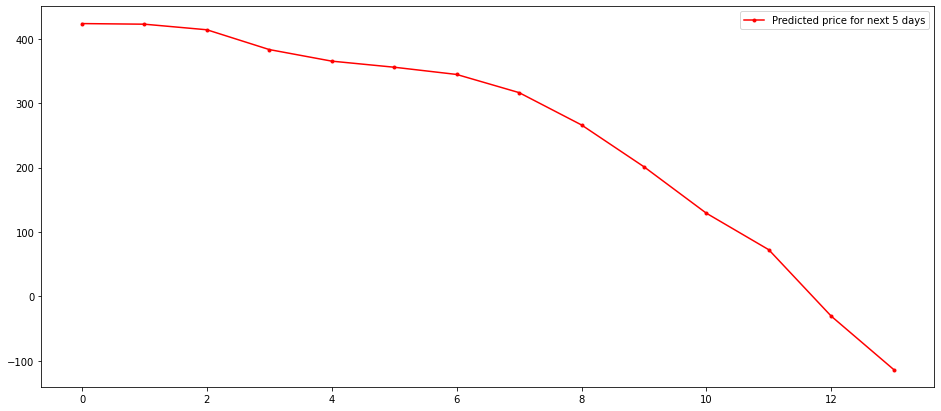

In [73]:
plt.figure(figsize=(16,7))

plt.plot(predicted_5_days_forecast_price_test_x.reshape(-1,)
, 'r', marker='.', label='Predicted price for next 5 days')



plt.legend()

plt.show()